# Statements

Esta tabla contiene la información de las sentencias.

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *
from domains import *

full_table = get_data('statements')

# Table name, features and target.
TABLE_NAME = 'statements'
TABLE_FEATURES = ['statement__category', 'statement__parent', 'statement__statement_role', 'statement__first_child_category','statement__second_child_category','statement__third_child_category', 'statement__height', 'statement__depth', 'statement__has_or_else', 'statement__body_size', 'statement__expertise_level']
TABLE_TARGET = 'statement__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2025-01-15 10:56:36.421725 Loading data ...
2025-01-15 10:56:46.303750 Data successfully load!!
2025-01-15 10:56:46.303750 Creating data cache files ...
2025-01-15 10:56:47.453776 Data cache files successfully created!!
Features shape: (279495, 11)
Target shape: (279495,)
As we can see the downloaded data contains a total of 279495 instances. For each instance we have 11 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279495 entries, 0 to 279494
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   statement__category               279495 non-null  object 
 1   statement__parent                 279495 non-null  object 
 2   statement__statement_role         279495 non-null  object 
 3   statement__first_child_category   246539 non-null  object 
 4   statement__second_child_category  160115 non-null  object 
 5   statement__third_child_category   4620 non-null    object 
 6   statement__height                 279495 non-null  int64  
 7   statement__depth                  279495 non-null  int64  
 8   statement__has_or_else            67770 non-null   object 
 9   statement__body_size              70028 non-null   float64
 10  statement__expertise_level        279495 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 23.

Cómo podemos ver la tabla está compuesta por 3 variables numéricas y 8 de tipo objeto.

### 2.1 - Equilibrado de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "PROFESSIONAL"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for PROFESSIONAL class.")

The dataset contains 46.03% instances for BEGINNER class and 0.0% for EXPERT class.


### 2.2 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [4]:
X.isnull().sum()

statement__category                      0
statement__parent                        0
statement__statement_role                0
statement__first_child_category      32956
statement__second_child_category    119380
statement__third_child_category     274875
statement__height                        0
statement__depth                         0
statement__has_or_else              211725
statement__body_size                209467
statement__expertise_level               0
dtype: int64

### IMPORTANTE
Los nulos se deben a que esas variables solo son aplicables para ciertas categorias

In [5]:
print_empty_cols(X)

statement__category
-------------------
0 instancias no tienen un valor para la columna statement__category


statement__parent
-----------------
0 instancias no tienen un valor para la columna statement__parent


statement__statement_role
-------------------------
0 instancias no tienen un valor para la columna statement__statement_role


statement__first_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__first_child_category


statement__second_child_category
--------------------------------
0 instancias no tienen un valor para la columna statement__second_child_category


statement__third_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__third_child_category


statement__height
-----------------
0 instancias no tienen un valor para la columna statement__height


statement__depth
----------------
0 instancias no tienen un valor para la columna statement__depth


statement__h

### 2.3 - Describimos los valores de las variables de la tabla.

In [6]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
statement__category,279495,20,AssignmentStmt,129226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__parent,279495,11,If,75645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__statement_role,279495,19,FunctionDefBody,56084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__first_child_category,246539,29,Variable,144353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__second_child_category,160115,31,Call,67204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__third_child_category,4620,22,Call,2868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__height,279495.0,NaN,NaN,NaN,3.154858,2.028645,1.0,2.0,3.0,4.0,38.0
statement__depth,279495.0,NaN,NaN,NaN,2.79249,2.167396,0.0,1.0,3.0,4.0,38.0
statement__has_or_else,67770,2,False,48941,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__body_size,70028.0,NaN,NaN,NaN,1.990447,2.267037,1.0,1.0,1.0,2.0,66.0


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [7]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "statement__depth": [(0.0, 1.0), (1.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 0.0 max: 82.0
    "statement__height": [(0.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 1.0 max: 54.0
    "statement__body_size": [(1.0, 2.0), (2.0, inf)],  # min: 1.0 max: 276. Los Unkonwn son los None
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['statement__depth'], 10))
print(get_statistics(X_copy, ['statement__height'], 10))
print(get_statistics(X_copy, ['statement__body_size'], 10))
print(get_statistics(X_copy, ['statement__category'], 10))
print(get_statistics(X_copy, ['statement__first_child_category'], 10))
print(get_statistics(X_copy, ['statement__second_child_category'], 10))
print(get_statistics(X_copy, ['statement__third_child_category'], 10))
print(get_statistics(X_copy, ['statement__parent'], 10))
print(get_statistics(X_copy, ['statement__statement_role'], 10))
print(get_statistics(X_copy, ['statement__has_or_else'], 10))


# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['module__function_defs_pct', 'module__number_of_classes'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
statement__depth  count  percentage
       [1.0_3.0) 106461   38.090485
       [4.0_inf]  82225   29.419131
       [3.0_4.0)  59906   21.433657
       [0.0_1.0)  30903   11.056727

statement__height  count  percentage
        [4.0_inf]  85918   30.740443
        [3.0_4.0)  79802   28.552210
        [2.0_3.0)  69940   25.023703
        [0.0_2.0)  43835   15.683644

statement__body_size  count  percentage
             unknown 209467   74.944811
           [1.0_2.0)  42309   15.137659
           [2.0_inf]  27719    9.917530

statement__category  count  percentage
     AssignmentStmt 129226   46.235532
                 If  45120   16.143401
             Return  25169    9.005170
         ImportFrom  19764    7.071325
                For  15468    5.534267
             Assert   7663    2.741731
AugmentedAssignment   6925    2.477683
             Import   6631    2.372493
AnnotatedAssignment   5801    2.075529
              While   5129    1.835095

statement__first_ch

In [8]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (279495, 139)
Target shape: (279495,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

In [9]:
#plt.figure(figsize=(12, 8))
#sns.heatmap(X.corr(method='spearman'), annot=False)

Se aprecian muchas relaciones pero habrá que mirar como mejorar este diagrama para que sea legible

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 10 variable (1 booleana, 3 numericas, 6 categorica) se hara un analisis detallado

### Variable has_or_else (1/10)
Esta variable es de tipo booleano y representa si ciertas categorias de statements tienen la clausula else. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

<Axes: xlabel='statement__has_or_else', ylabel='Count'>

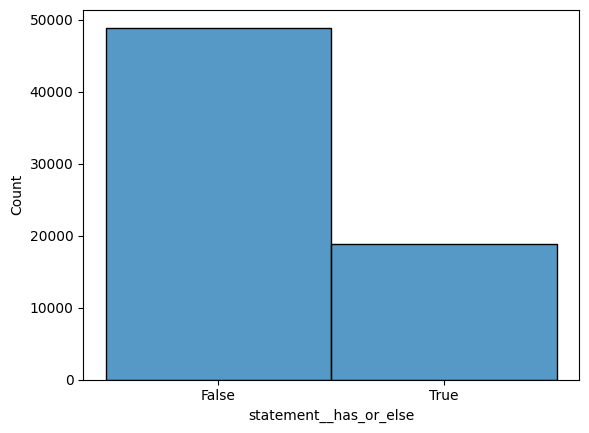

In [10]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(full_table['statement__has_or_else'], discrete=True)

In [11]:
num_true_values = len(full_table[full_table['statement__has_or_else'] == True])
num_false_values = len(full_table[full_table['statement__has_or_else'] == False])
std = full_table['statement__has_or_else'].std()
freq_true = len(full_table[full_table['statement__has_or_else'] == True]) / len(full_table['statement__has_or_else'])
freq_false = len(full_table[full_table['statement__has_or_else'] == False]) / len(full_table['statement__has_or_else'])
print(f'La variable has_or_else contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a False es {freq_false}.')

La variable has_or_else contiene 18829 valores verdaderos y 48941 valores falsos. Y, la desviación típica es de 0.447935791919924
La frecuencia con la que programa puede tener la variable has_or_else a True es 0.06736793144778977.
La frecuencia con la que programa puede tener la variable has_or_else a False es 0.17510510027013004.


### IMPORTANTE
No suma el 100% debido a los valores nulos

In [12]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(full_table, 'statement__has_or_else', possible_values)

La variable statement__has_or_else contiene 3 valores distintos.
El umbral de outlier es de 0.06666666666666667%
La variable statement__has_or_else toma el valor de None en un 75.75% de los items.
La variable statement__has_or_else toma el valor de False en un 17.51% de los items.
La variable statement__has_or_else toma el valor de True en un 6.737% de los items.


In [13]:
full_table[full_table['statement__has_or_else'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__category,statement__parent,statement__statement_role,statement__first_child_category,statement__second_child_category,statement__third_child_category,statement__height,statement__depth,statement__has_or_else,statement__body_size,statement__expertise_level
count,18829,18829,18829,18810,23,0,18829.000000,18829.000000,18829,18829.000000,18829
unique,4,11,18,12,2,0,NaN,NaN,1,NaN,2
top,If,If,IfElseBody,Compare,Call,NaN,NaN,NaN,True,NaN,BEGINNER
freq,18779,10253,7134,13142,21,NaN,NaN,NaN,18829,NaN,12936
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.351214,5.814063,NaN,1.870413,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,3.168288,3.383184,NaN,2.002996,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,4.000000,NaN,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,5.000000,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,7.000000,NaN,2.000000,NaN


### Variable height (2/10)
Esta variable representa la distancia del statement al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 38. Con una media de 3.15.

<Axes: ylabel='statement__height'>

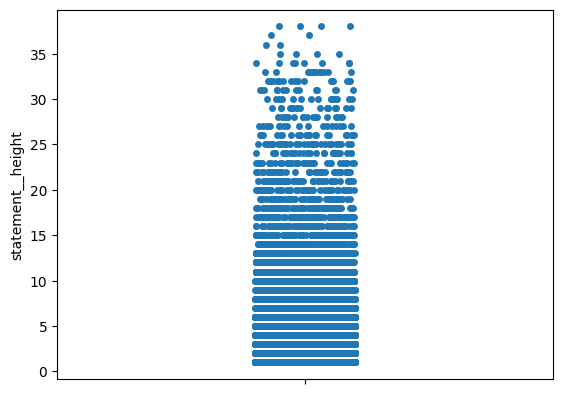

In [14]:
sns.stripplot(X['statement__height'])

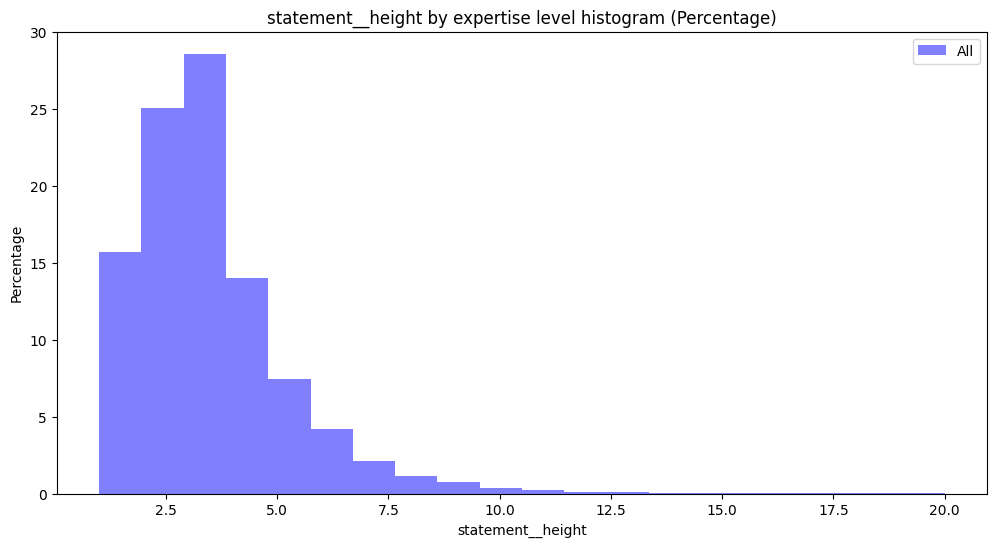

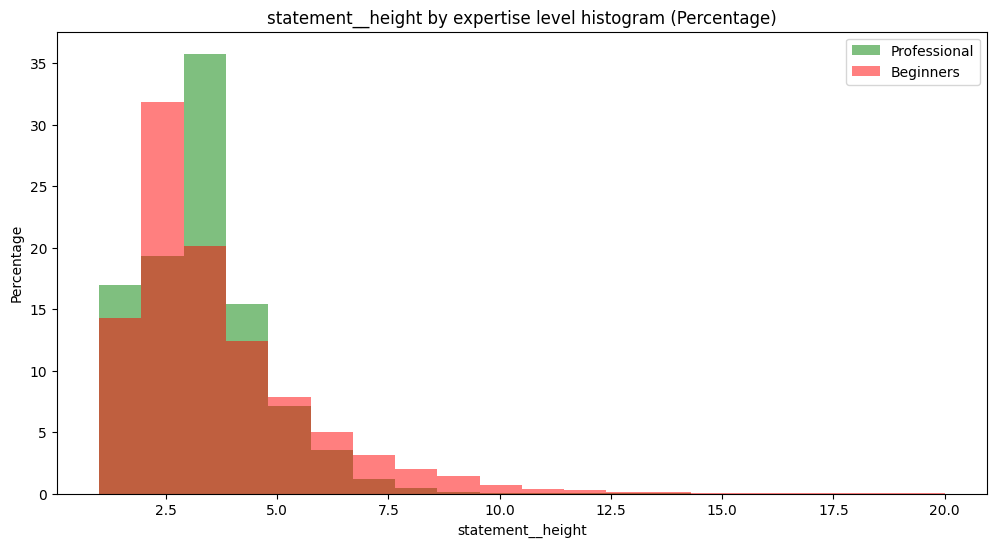

In [15]:
print_histogram(X, 'statement__height', 'statement__expertise_level', bins=20, include_beginners=False, include_experts=False, max_value=20)
print_histogram(X, 'statement__height', 'statement__expertise_level', bins=20, include_all=False, max_value=20)

In [16]:
print_outliers_for_df_column(X, 'statement__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8664243350157866
Rango valores atípicos extremos (Tukey): [-4.0,10.0]
Rango valores atípicos leves (Tukey): [-1.0,7.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.8554128564838772,99.99629804866747]
-3.0IQR: 0 instancias tienen un valor para statement__height inferior a -4.0 (Q1-3*IQR) para statement__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__height inferior a -1.0 (Q1-1.5*IQR) para statement__height. Representando un 0.0% del total de instancias.
+1.5IQR: 8376 instancias tienen un valor para statement__height superior a 7.0 (Q3+1.5*IQR) para statement__height. Representando un 2.997% del total de instancias.
+3.0IQR: 2101 instancias tienen un valor para statement__height superior a 10.0 (Q3-3*IQR) para statement__height. Representando un 0.7517% del total de instancias.
L: 43835 instancias tienen un valor para statement__height inferior a 1.85541285648

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 10.0 (Con un MC de 86 usamos Tuckey Extremo)

In [17]:
X[X['statement__height'] > 10].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_SetLiteral,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_PROFESSIONAL
count,2101.000000,2101.000000,931.000000,2101.0,2101.0,2101.000000,2101.0,2101.000000,2101.000000,2101.000000,...,2101.0,2101.0,2101.0,2101.0,2101.0,2101.0,2101.000000,2101.000000,2101.000000,2101.000000
mean,15.352689,4.693479,1.627283,0.0,0.0,0.324131,0.0,0.100904,0.028558,0.003332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.138030,0.305093,0.923370,0.076630
std,5.552591,5.050346,1.194822,0.0,0.0,0.468161,0.0,0.301274,0.166600,0.057639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.345013,0.460556,0.266067,0.266067
min,11.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
50%,13.000000,3.000000,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
75%,17.000000,6.000000,2.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000
max,38.000000,29.000000,11.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### Variable depth (3/10)
Esta variable representa la distancia desde el statement hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 38. Con una media de 2.79.

<Axes: ylabel='statement__depth'>

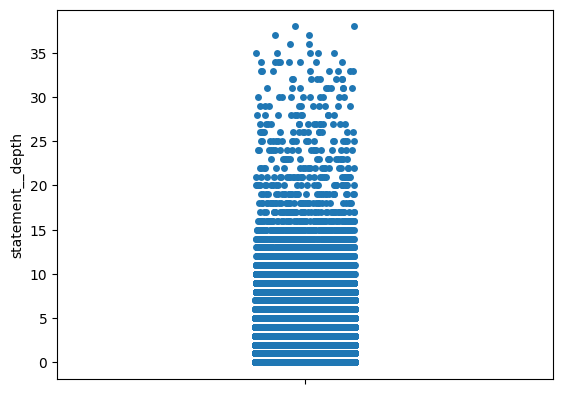

In [18]:
sns.stripplot(X['statement__depth'])

### IMPORTANTE
Los valores maximos estan muy alejados de los siguientes.

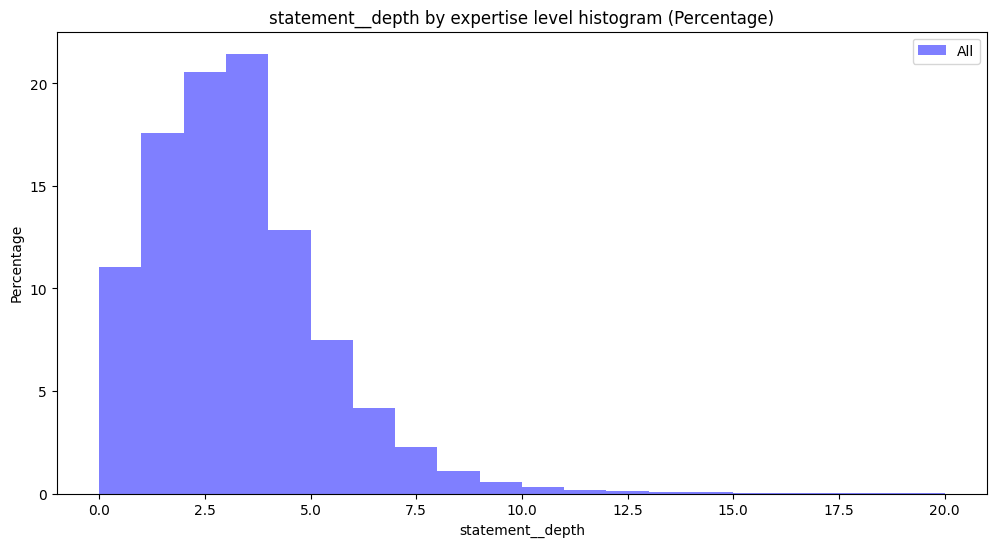

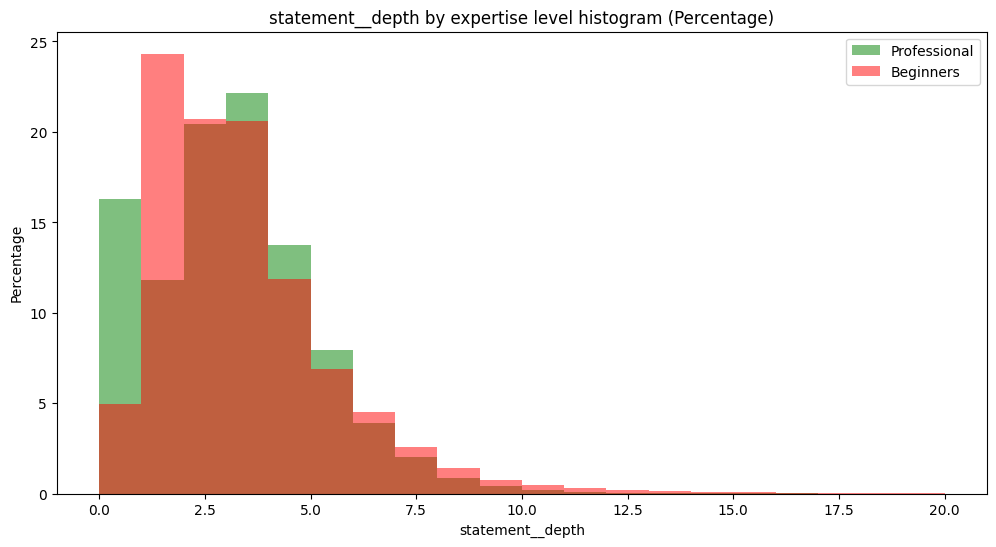

In [19]:
print_histogram(X, 'statement__depth', 'statement__expertise_level', bins=20, include_beginners=False, include_experts=False, max_value=20)
print_histogram(X, 'statement__depth', 'statement__expertise_level', bins=20, include_all=False, max_value=20)

In [20]:
print_outliers_for_df_column(X, 'statement__depth')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8378582738808666
Rango valores atípicos extremos (Tukey): [-8.0,13.0]
Rango valores atípicos leves (Tukey): [-3.5,8.5]
Rango valores atípicos extremos (Fixed BoxPlot): [0.7603142435731,132.44624530002486]
-3.0IQR: 0 instancias tienen un valor para statement__depth inferior a -8.0 (Q1-3*IQR) para statement__depth. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__depth inferior a -3.5 (Q1-1.5*IQR) para statement__depth. Representando un 0.0% del total de instancias.
+1.5IQR: 4261 instancias tienen un valor para statement__depth superior a 8.5 (Q3+1.5*IQR) para statement__depth. Representando un 1.525% del total de instancias.
+3.0IQR: 738 instancias tienen un valor para statement__depth superior a 13.0 (Q3-3*IQR) para statement__depth. Representando un 0.264% del total de instancias.
L: 30903 instancias tienen un valor para statement__depth inferior a 0.7603142435731 para state

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 13.0 (Con un MC de 83 usamos Tuckey Extremo)

In [21]:
X[X['statement__depth'] > 13].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_SetLiteral,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_PROFESSIONAL
count,738.000000,738.000000,733.000000,738.0,738.0,738.000000,738.0,738.0,738.0,738.0,...,738.0,738.0,738.0,738.0,738.0,738.0,738.000000,738.000000,738.000000,738.000000
mean,6.781843,18.886179,2.349250,0.0,0.0,0.006775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.257453,0.735772,0.906504,0.093496
std,5.572499,5.575489,2.820832,0.0,0.0,0.082087,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.437527,0.441220,0.291324,0.291324
min,1.000000,14.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,15.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
50%,4.000000,17.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000
75%,9.000000,21.750000,3.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.000000
max,26.000000,38.000000,38.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### Variable body_size (4/10)
Esta variable representa el número de sentencias o expresiones que se definen dentro del cuerpo de ciertas categorías de sentencias. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 66. Con una media de 1.99.

<Axes: ylabel='statement__body_size'>

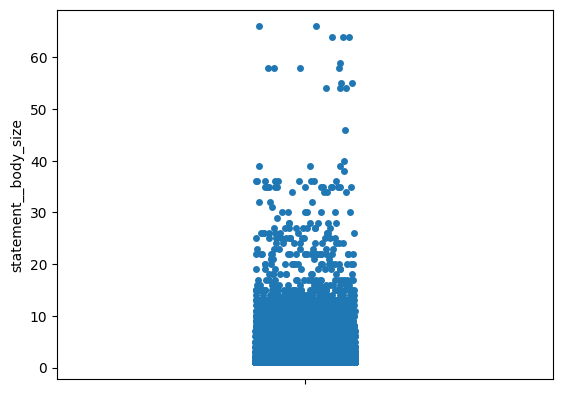

In [22]:
sns.stripplot(X['statement__body_size'])

### IMPORTANTE
El valor maximo esta muy alejado de los siguientes.

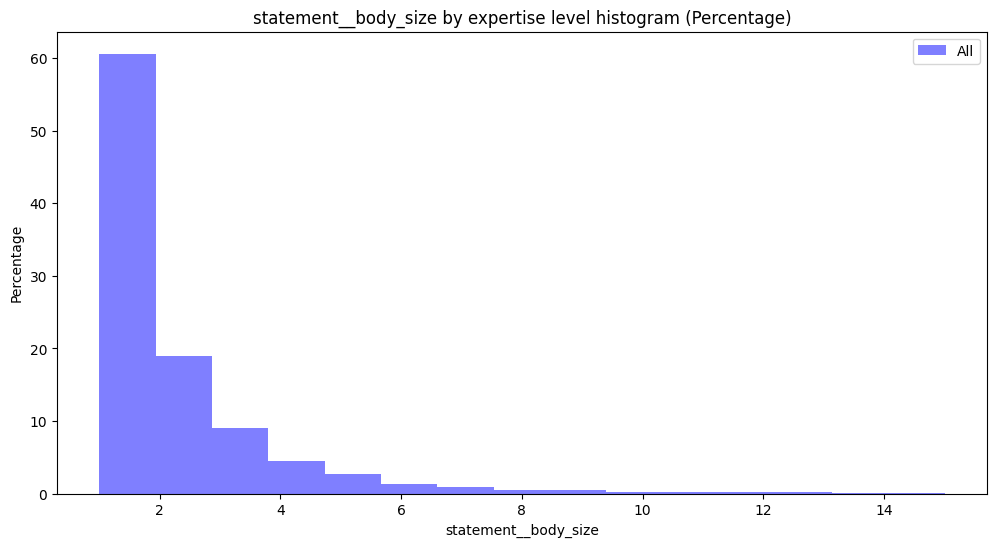

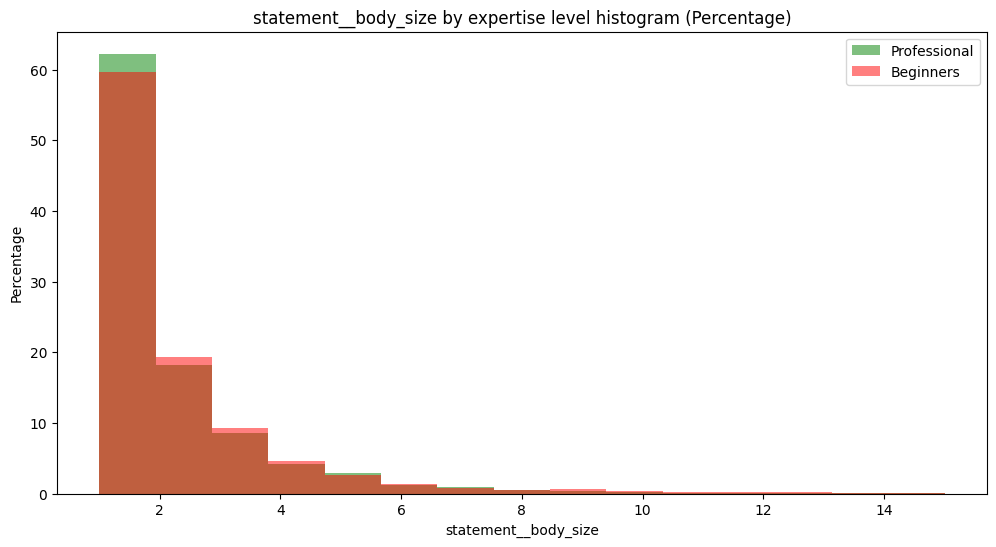

In [23]:
print_histogram(X, 'statement__body_size', 'statement__expertise_level', bins=15, include_beginners=False, include_experts=False, max_value=15)
print_histogram(X, 'statement__body_size', 'statement__expertise_level', bins=15, include_all=False, max_value=15)

In [24]:
print_outliers_for_df_column(X,'statement__body_size')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9674190614296898
Rango valores atípicos extremos (Tukey): [-2.0,5.0]
Rango valores atípicos leves (Tukey): [-0.5,3.5]
Rango valores atípicos extremos (Fixed BoxPlot): [0.9492326377819119,73.8903005605792]
-3.0IQR: 0 instancias tienen un valor para statement__body_size inferior a -2.0 (Q1-3*IQR) para statement__body_size. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para statement__body_size inferior a -0.5 (Q1-1.5*IQR) para statement__body_size. Representando un 0.0% del total de instancias.
+1.5IQR: 8216 instancias tienen un valor para statement__body_size superior a 3.5 (Q3+1.5*IQR) para statement__body_size. Representando un 2.94% del total de instancias.
+3.0IQR: 3161 instancias tienen un valor para statement__body_size superior a 5.0 (Q3-3*IQR) para statement__body_size. Representando un 1.131% del total de instancias.
L: 0 instancias tienen un valor para statement__body_size inferi

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 5.0 (Con un MC de 96.7 usamos Tukey Extremo)

In [47]:
X[X['statement__body_size'] > 5].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,statement__height,statement__depth,statement__body_size,statement__category_AnnotatedAssignment,statement__category_Assert,statement__category_AssignmentStmt,statement__category_AsyncWith,statement__category_AugmentedAssignment,statement__category_Break,statement__category_Continue,...,statement__third_child_category_SetLiteral,statement__third_child_category_StringLiteral,statement__third_child_category_Ternary,statement__third_child_category_TupleLiteral,statement__third_child_category_UnaryArithmetic,statement__third_child_category_Variable,statement__has_or_else_False,statement__has_or_else_True,statement__expertise_level_BEGINNER,statement__expertise_level_PROFESSIONAL
count,3161.000000,3161.000000,3161.000000,3161.0,3161.0,3161.0,3161.000000,3161.0,3161.0,3161.0,...,3161.0,3161.0,3161.0,3161.0,3161.0,3161.0,3161.000000,3161.000000,3161.000000,3161.000000
mean,3.145207,6.473901,9.368871,0.0,0.0,0.0,0.000316,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.732363,0.225878,0.673521,0.326479
std,1.740830,2.384423,5.895018,0.0,0.0,0.0,0.017786,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.442797,0.418225,0.468999,0.468999
min,1.000000,1.000000,6.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,6.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.000000,6.000000,8.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000
75%,4.000000,8.000000,10.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.000000,1.000000
max,18.000000,22.000000,66.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### Variable category (5/10)
Esta variable es de tipo categórica y representa el tipo de sentencia.

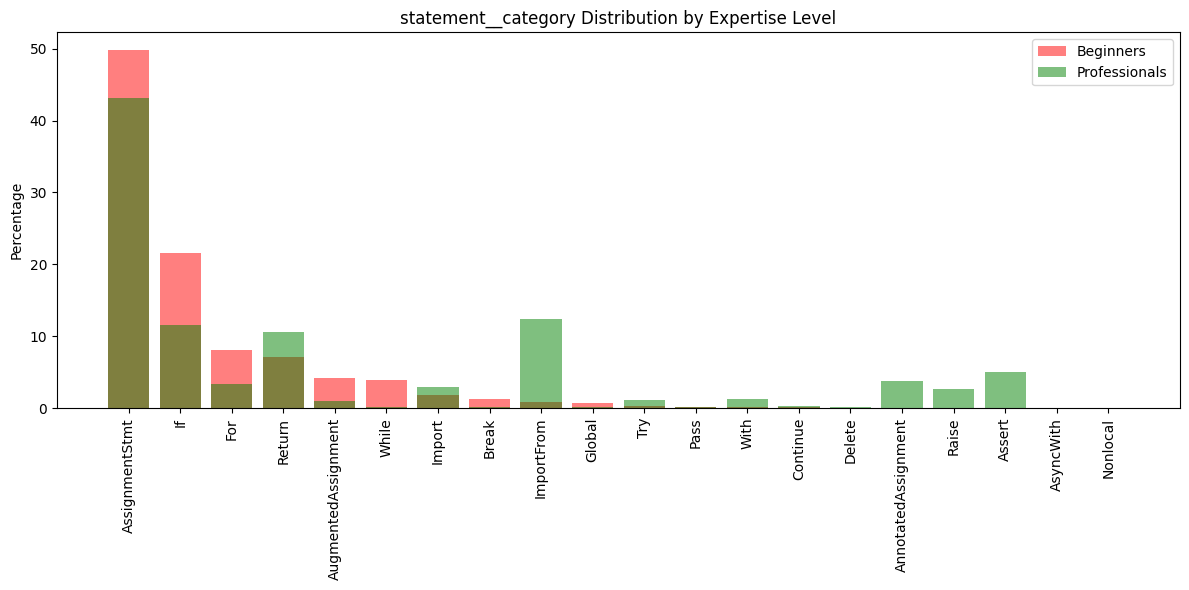

In [26]:
print_categorical_histogram(full_table, 'statement__category', TABLE_TARGET, vertical=True, include_all=False)

In [27]:
print_frequency_anal_for_cat_var(full_table, 'statement__category')

La variable statement__category contiene 20 valores distintos.
El umbral de outlier es de 0.01%
La variable statement__category toma el valor de AssignmentStmt en un 46.24% de los items.
La variable statement__category toma el valor de If en un 16.14% de los items.
La variable statement__category toma el valor de Return en un 9.005% de los items.
La variable statement__category toma el valor de ImportFrom en un 7.071% de los items.
La variable statement__category toma el valor de For en un 5.534% de los items.
La variable statement__category toma el valor de Assert en un 2.742% de los items.
La variable statement__category toma el valor de AugmentedAssignment en un 2.478% de los items.
La variable statement__category toma el valor de Import en un 2.372% de los items.
La variable statement__category toma el valor de AnnotatedAssignment en un 2.076% de los items.
La variable statement__category toma el valor de While en un 1.835% de los items.
La variable statement__category toma el valo

In [28]:
print_values_usage_for_cat_var(full_table, 'statement__category', STATEMENT_CATEGORY_VALUES)

La variable statement__category puede tomar 24 valores distintos
	20 (83.33%) valores utilizados
	4 (16.67%) valores NO utilizados
		La variable statement__category nunca toma valor ExceptHandler.
		La variable statement__category nunca toma valor Match.
		La variable statement__category nunca toma valor TypeAlias.
		La variable statement__category nunca toma valor AsyncFor.


### Variable parent (6/10)
Esta variable es de tipo categórica y representa el tipo del padre de la sentencia.

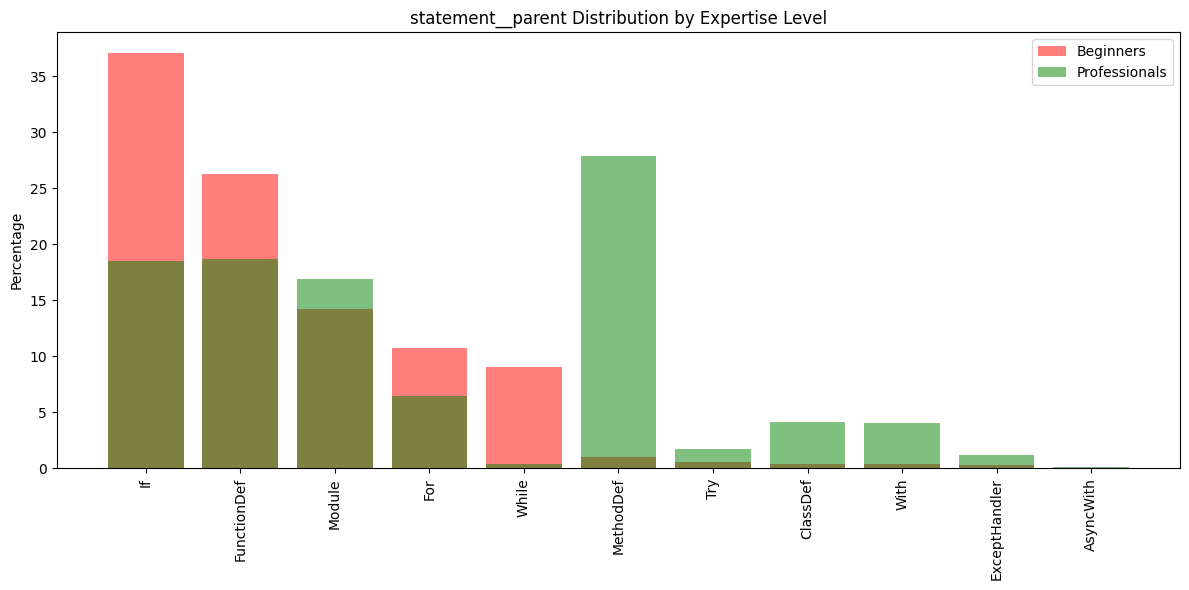

In [29]:
print_categorical_histogram(full_table, 'statement__parent', TABLE_TARGET, vertical=True, include_all=False)

In [30]:
print_frequency_anal_for_cat_var(full_table, 'statement__parent')

La variable statement__parent contiene 11 valores distintos.
El umbral de outlier es de 0.018181818181818184%
La variable statement__parent toma el valor de If en un 27.06% de los items.
La variable statement__parent toma el valor de FunctionDef en un 22.18% de los items.
La variable statement__parent toma el valor de Module en un 15.68% de los items.
La variable statement__parent toma el valor de MethodDef en un 15.51% de los items.
La variable statement__parent toma el valor de For en un 8.415% de los items.
La variable statement__parent toma el valor de While en un 4.398% de los items.
La variable statement__parent toma el valor de ClassDef en un 2.425% de los items.
La variable statement__parent toma el valor de With en un 2.325% de los items.
La variable statement__parent toma el valor de Try en un 1.204% de los items.
La variable statement__parent toma el valor de ExceptHandler en un 0.7446% de los items.
La variable statement__parent toma el valor de AsyncWith en un 0.05403% de 

In [31]:
print_values_usage_for_cat_var(full_table, 'statement__parent', STATEMENT_PARENT_VALUES)

La variable statement__parent puede tomar 28 valores distintos
	11 (39.29%) valores utilizados
	17 (60.71%) valores NO utilizados
		La variable statement__parent nunca toma valor Raise.
		La variable statement__parent nunca toma valor Global.
		La variable statement__parent nunca toma valor Break.
		La variable statement__parent nunca toma valor Continue.
		La variable statement__parent nunca toma valor AugmentedAssignment.
		La variable statement__parent nunca toma valor Pass.
		La variable statement__parent nunca toma valor AssignmentStmt.
		La variable statement__parent nunca toma valor Assert.
		La variable statement__parent nunca toma valor Match.
		La variable statement__parent nunca toma valor TypeAlias.
		La variable statement__parent nunca toma valor AsyncFor.
		La variable statement__parent nunca toma valor ImportFrom.
		La variable statement__parent nunca toma valor AnnotatedAssignment.
		La variable statement__parent nunca toma valor Nonlocal.
		La variable statement__paren

### Variable statement_role (7/10)
Esta variable es de tipo categórica y representa el rol que representa la sentencia en su padre.

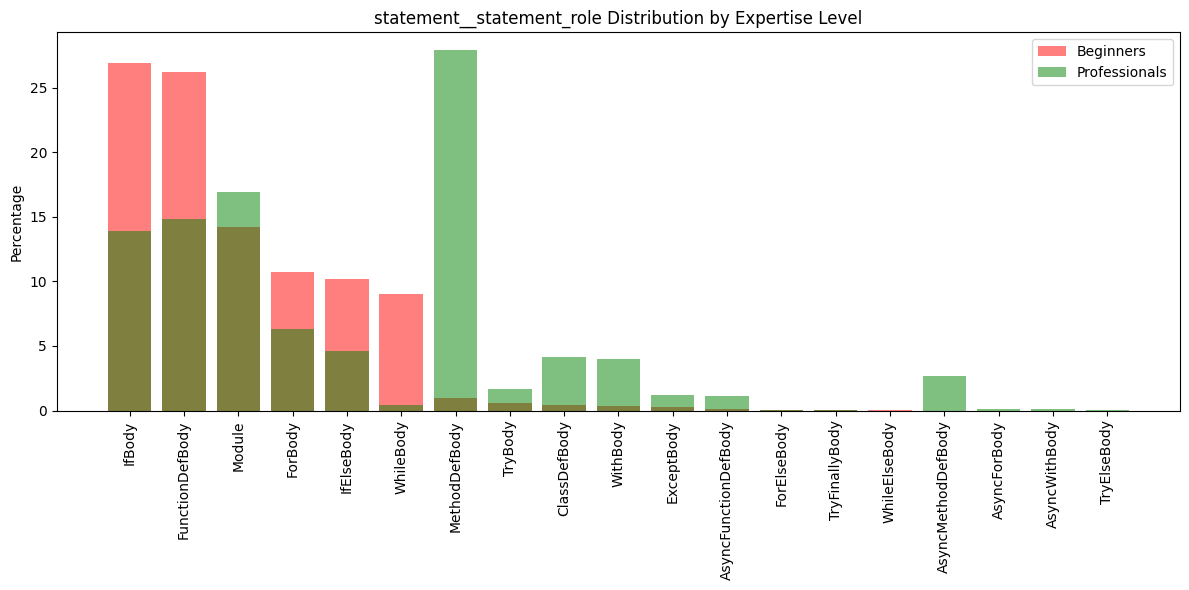

In [32]:
print_categorical_histogram(full_table, 'statement__statement_role', TABLE_TARGET, vertical=True, include_all=False)

In [33]:
print_frequency_anal_for_cat_var(full_table, 'statement__statement_role')

La variable statement__statement_role contiene 19 valores distintos.
El umbral de outlier es de 0.010526315789473684%
La variable statement__statement_role toma el valor de FunctionDefBody en un 20.07% de los items.
La variable statement__statement_role toma el valor de IfBody en un 19.9% de los items.
La variable statement__statement_role toma el valor de Module en un 15.68% de los items.
La variable statement__statement_role toma el valor de MethodDefBody en un 15.51% de los items.
La variable statement__statement_role toma el valor de ForBody en un 8.345% de los items.
La variable statement__statement_role toma el valor de IfElseBody en un 7.166% de los items.
La variable statement__statement_role toma el valor de WhileBody en un 4.396% de los items.
La variable statement__statement_role toma el valor de ClassDefBody en un 2.425% de los items.
La variable statement__statement_role toma el valor de WithBody en un 2.325% de los items.
La variable statement__statement_role toma el valo

In [34]:
print_values_usage_for_cat_var(full_table, 'statement__statement_role', STATEMENT_ROLE_VALUES)

La variable statement__statement_role puede tomar 23 valores distintos
	19 (82.61%) valores utilizados
	4 (17.39%) valores NO utilizados
		La variable statement__statement_role nunca toma valor AsyncForElseBody.
		La variable statement__statement_role nunca toma valor TryHandlerStar.
		La variable statement__statement_role nunca toma valor CaseBody.
		La variable statement__statement_role nunca toma valor TryHandler.


### Variable first_child_category (8/10)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la sentencia.

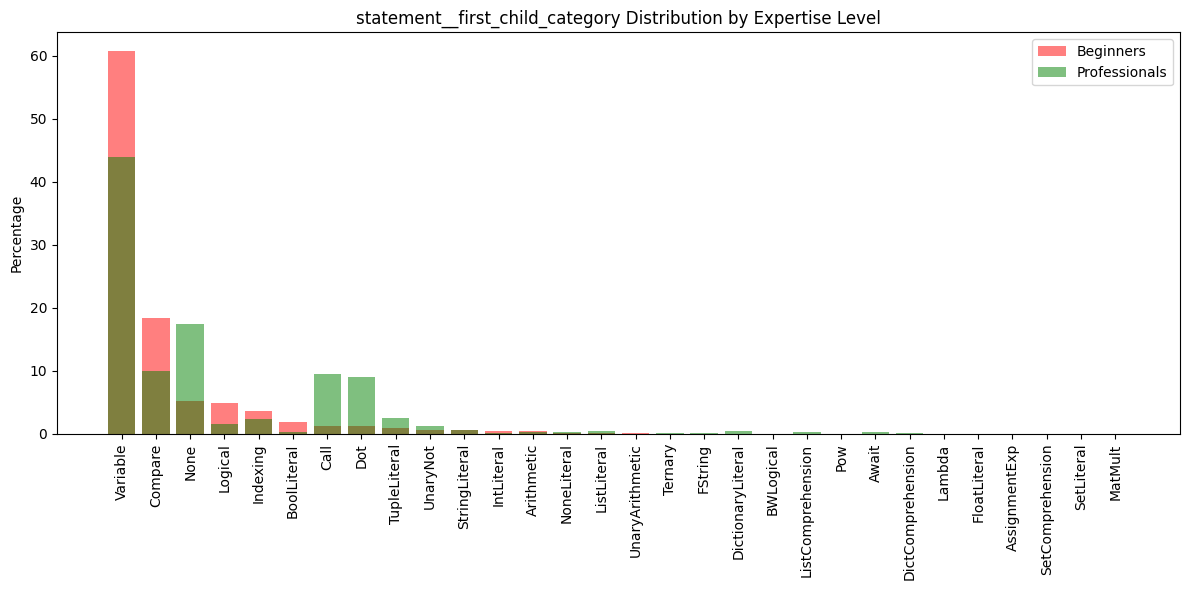

In [35]:
print_categorical_histogram(full_table, 'statement__first_child_category', TABLE_TARGET, vertical=True, fillna=True, include_all=False)

In [36]:
print_frequency_anal_for_cat_var(full_table, 'statement__first_child_category')

La variable statement__first_child_category contiene 30 valores distintos.
El umbral de outlier es de 0.006666666666666667%
La variable statement__first_child_category toma el valor de Variable en un 51.65% de los items.
La variable statement__first_child_category toma el valor de Compare en un 13.75% de los items.
La variable statement__first_child_category toma el valor de None en un 11.79% de los items.
La variable statement__first_child_category toma el valor de Call en un 5.673% de los items.
La variable statement__first_child_category toma el valor de Dot en un 5.373% de los items.
La variable statement__first_child_category toma el valor de Logical en un 3.058% de los items.
La variable statement__first_child_category toma el valor de Indexing en un 2.97% de los items.
La variable statement__first_child_category toma el valor de TupleLiteral en un 1.74% de los items.
La variable statement__first_child_category toma el valor de BoolLiteral en un 1.028% de los items.
La variable s

In [37]:
print_values_usage_for_cat_var(full_table, 'statement__first_child_category', STATEMENT_CHILDREN_VALUES)

La variable statement__first_child_category puede tomar 42 valores distintos
	30 (71.43%) valores utilizados
	13 (30.95%) valores NO utilizados
		La variable statement__first_child_category nunca toma valor None.
		La variable statement__first_child_category nunca toma valor FormattedValue.
		La variable statement__first_child_category nunca toma valor UnaryBWNot.
		La variable statement__first_child_category nunca toma valor Shift.
		La variable statement__first_child_category nunca toma valor NoneType.
		La variable statement__first_child_category nunca toma valor ComplexLiteral.
		La variable statement__first_child_category nunca toma valor Yield.
		La variable statement__first_child_category nunca toma valor Parameter.
		La variable statement__first_child_category nunca toma valor GeneratorComprehension.
		La variable statement__first_child_category nunca toma valor Star.
		La variable statement__first_child_category nunca toma valor Slice.
		La variable statement__first_child_cate

### Variable second_child_category (9/10)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la sentencia.

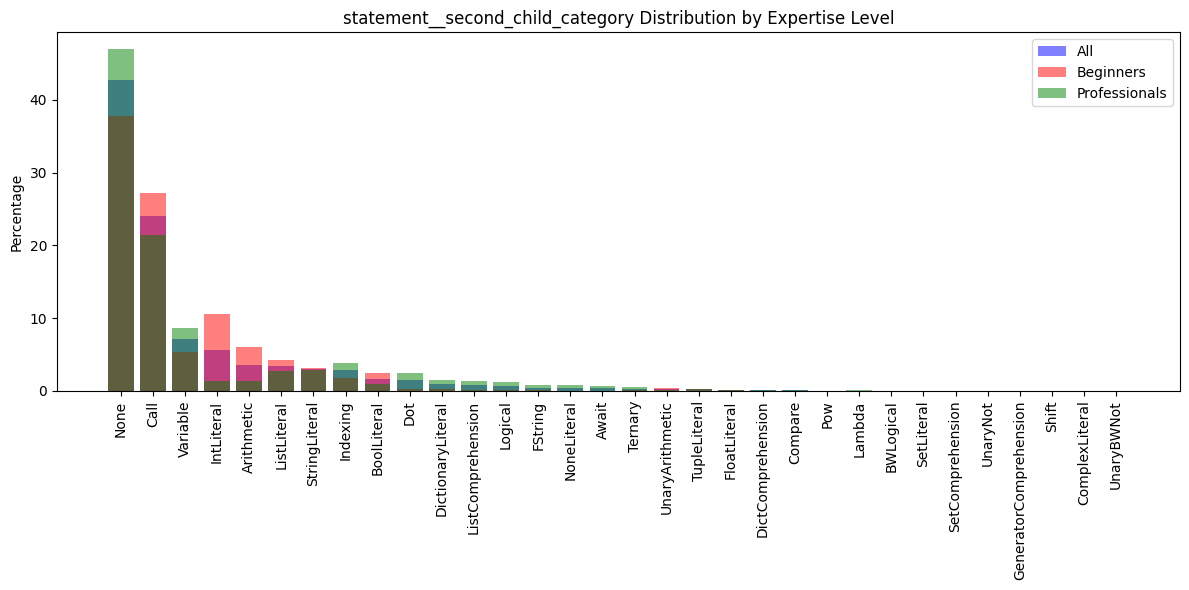

In [38]:
print_categorical_histogram(full_table, 'statement__second_child_category', TABLE_TARGET, vertical=True, fillna=True)

In [39]:
print_frequency_anal_for_cat_var(full_table, 'statement__second_child_category')

La variable statement__second_child_category contiene 32 valores distintos.
El umbral de outlier es de 0.00625%
La variable statement__second_child_category toma el valor de None en un 42.71% de los items.
La variable statement__second_child_category toma el valor de Call en un 24.04% de los items.
La variable statement__second_child_category toma el valor de Variable en un 7.121% de los items.
La variable statement__second_child_category toma el valor de IntLiteral en un 5.563% de los items.
La variable statement__second_child_category toma el valor de Arithmetic en un 3.554% de los items.
La variable statement__second_child_category toma el valor de ListLiteral en un 3.407% de los items.
La variable statement__second_child_category toma el valor de StringLiteral en un 2.962% de los items.
La variable statement__second_child_category toma el valor de Indexing en un 2.873% de los items.
La variable statement__second_child_category toma el valor de BoolLiteral en un 1.64% de los items.


In [40]:
print_values_usage_for_cat_var(full_table, 'statement__second_child_category', STATEMENT_CHILDREN_VALUES)

La variable statement__second_child_category puede tomar 42 valores distintos
	32 (76.19%) valores utilizados
	11 (26.19%) valores NO utilizados
		La variable statement__second_child_category nunca toma valor None.
		La variable statement__second_child_category nunca toma valor FormattedValue.
		La variable statement__second_child_category nunca toma valor NoneType.
		La variable statement__second_child_category nunca toma valor AssignmentExp.
		La variable statement__second_child_category nunca toma valor Yield.
		La variable statement__second_child_category nunca toma valor Parameter.
		La variable statement__second_child_category nunca toma valor MatMult.
		La variable statement__second_child_category nunca toma valor Star.
		La variable statement__second_child_category nunca toma valor Slice.
		La variable statement__second_child_category nunca toma valor EllipsisLiteral.
		La variable statement__second_child_category nunca toma valor YieldFrom.
La variable statement__second_child_

### Variable third_child_category (10/10)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la sentencia.

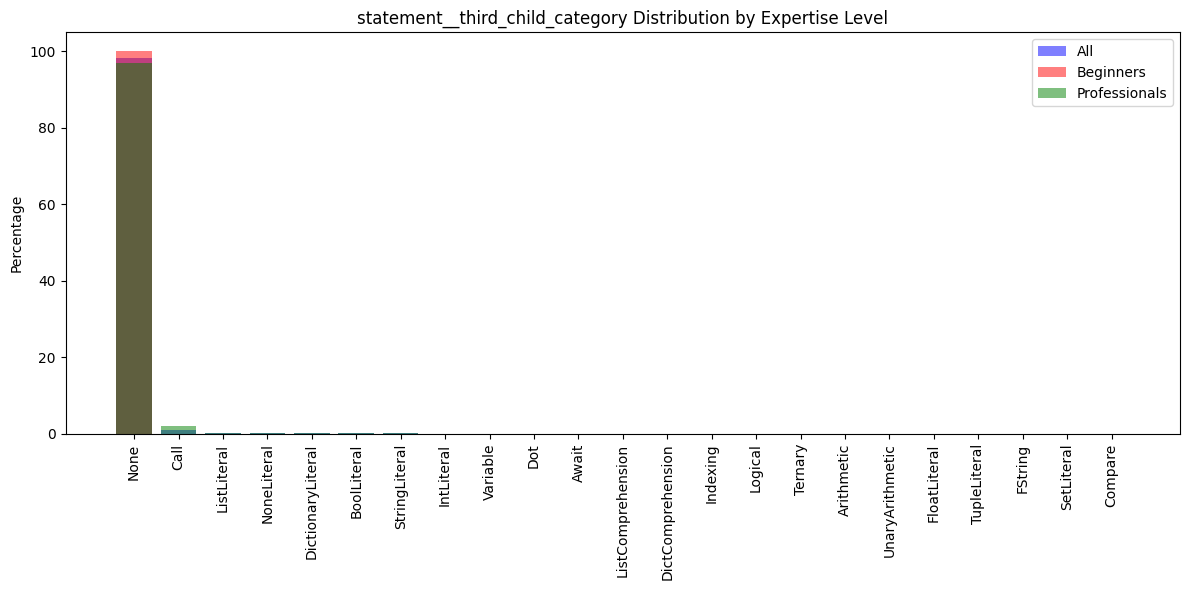

In [48]:
print_categorical_histogram(full_table, 'statement__third_child_category', TABLE_TARGET, vertical=True, fillna=True)

In [42]:
print_frequency_anal_for_cat_var(full_table, 'statement__third_child_category')

La variable statement__third_child_category contiene 23 valores distintos.
El umbral de outlier es de 0.008695652173913044%
La variable statement__third_child_category toma el valor de None en un 98.35% de los items.
La variable statement__third_child_category toma el valor de Call en un 1.026% de los items.
La variable statement__third_child_category toma el valor de ListLiteral en un 0.1549% de los items.
La variable statement__third_child_category toma el valor de NoneLiteral en un 0.1227% de los items.
La variable statement__third_child_category toma el valor de DictionaryLiteral en un 0.09911% de los items.
La variable statement__third_child_category toma el valor de BoolLiteral en un 0.08945% de los items.
La variable statement__third_child_category toma el valor de StringLiteral en un 0.05224% de los items.
La variable statement__third_child_category toma el valor de IntLiteral en un 0.02433% de los items.
La variable statement__third_child_category toma el valor de Variable en 

In [43]:
print_values_usage_for_cat_var(full_table, 'statement__third_child_category', STATEMENT_CHILDREN_VALUES)

La variable statement__third_child_category puede tomar 42 valores distintos
	23 (54.76%) valores utilizados
	20 (47.62%) valores NO utilizados
		La variable statement__third_child_category nunca toma valor FormattedValue.
		La variable statement__third_child_category nunca toma valor Shift.
		La variable statement__third_child_category nunca toma valor SetComprehension.
		La variable statement__third_child_category nunca toma valor UnaryNot.
		La variable statement__third_child_category nunca toma valor None.
		La variable statement__third_child_category nunca toma valor UnaryBWNot.
		La variable statement__third_child_category nunca toma valor Parameter.
		La variable statement__third_child_category nunca toma valor MatMult.
		La variable statement__third_child_category nunca toma valor NoneType.
		La variable statement__third_child_category nunca toma valor Pow.
		La variable statement__third_child_category nunca toma valor AssignmentExp.
		La variable statement__third_child_categor

## Multivariate

Isolation forest algorithm

In [44]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
X['statement__body_size'] = X['statement__body_size'].fillna(0) # Fill NaN values with 0
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,statement__category,statement__parent,statement__statement_role,statement__first_child_category,statement__second_child_category,statement__third_child_category,statement__height,statement__depth,statement__has_or_else,statement__body_size,statement__expertise_level
320,Assert,Try,TryBody,Call,StringLiteral,None,5,4,None,NaN,PROFESSIONAL
847,For,FunctionDef,FunctionDefBody,TupleLiteral,Dot,None,4,7,False,7.0,PROFESSIONAL
848,For,For,ForBody,TupleLiteral,Call,None,5,6,False,3.0,PROFESSIONAL
1823,For,With,WithBody,TupleLiteral,Call,None,3,5,False,5.0,PROFESSIONAL
1833,For,With,WithBody,TupleLiteral,Call,None,3,5,False,5.0,PROFESSIONAL
...,...,...,...,...,...,...,...,...,...,...,...
272026,For,For,ForBody,TupleLiteral,Call,None,5,8,False,3.0,BEGINNER
272036,For,For,ForBody,TupleLiteral,Call,None,5,8,False,3.0,BEGINNER
272121,With,Try,TryBody,Call,Variable,None,3,4,None,2.0,BEGINNER
272131,With,Try,TryBody,Call,Variable,None,3,4,None,2.0,BEGINNER


In [45]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
statement__height,336.0,3.244048,1.027950,1.0,3.0,3.0,4.0,6.0
statement__depth,336.0,7.193452,2.997723,2.0,6.0,7.0,8.0,22.0
statement__body_size,336.0,7.101191,5.751200,0.0,4.0,5.0,9.0,40.0
statement__category_AnnotatedAssignment,336.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
statement__category_Assert,336.0,0.002976,0.054554,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
statement__third_child_category_Variable,336.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
statement__has_or_else_False,336.0,0.684524,0.465398,0.0,0.0,1.0,1.0,1.0
statement__has_or_else_True,336.0,0.160714,0.367815,0.0,0.0,0.0,0.0,1.0
statement__expertise_level_BEGINNER,336.0,0.226190,0.418988,0.0,0.0,0.0,0.0,1.0


In [46]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
statement__height,279159.0,3.154751,2.029551,1.0,2.0,3.0,4.0,38.0
statement__depth,279159.0,2.787193,2.160819,0.0,1.0,3.0,4.0,38.0
statement__body_size,279159.0,0.490763,1.393504,0.0,0.0,0.0,0.0,66.0
statement__category_AnnotatedAssignment,279159.0,0.020780,0.142648,0.0,0.0,0.0,0.0,1.0
statement__category_Assert,279159.0,0.027447,0.163381,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
statement__third_child_category_Variable,279159.0,0.000233,0.015257,0.0,0.0,0.0,0.0,1.0
statement__has_or_else_False,279159.0,0.174492,0.379533,0.0,0.0,0.0,0.0,1.0
statement__has_or_else_True,279159.0,0.067256,0.250465,0.0,0.0,0.0,0.0,1.0
statement__expertise_level_BEGINNER,279159.0,0.460565,0.498443,0.0,0.0,0.0,1.0,1.0
